# Сравнение различных реализаций бустинга
Сюй Минчуань, 5 курс, ММП

данные взяты из https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

Компания, которая активно занимается большими данными и наукой о данных, хочет нанять специалистов по обработке данных из числа людей, успешно прошедших некоторые курсы, которые проводит компания. Задача состоит в том, чтобы предсказать вероятность того, что кандидат будет искать новую работу или будет работать в компании. - **Задача бинарной классификации**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 80,60
import seaborn as sns
pd.set_option('display.max_columns', None)
import time

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

import warnings
warnings.filterwarnings(action="ignore")

## 1. Описание датасета и предобработка данных

Датасет содержит небольшой объем данных (19158 строчек, 13 признаков + 1 таргет), поэтому удобно на нем быстро сделать эксперименты. 

Признаки и таргет датасета:
- `enrollee_id` : Unique ID for candidate
- `city`: City code
- `city_development_index` : Developement index of the city (scaled)
- `gender`: Gender of candidate
- `relevent_experience`: Relevant experience of candidate
- `enrolled_university`: Type of University course enrolled if any
- `education_level`: Education level of candidate
- `major_discipline` :Education major discipline of candidate
- `experience`: Candidate total experience in years
- `company_size`: No of employees in current employer's company
- `company_type`: Type of current employer
- `lastnewjob`: Difference in years between previous job and current job
- `training_hours`: training hours completed
- `target`: 0 – Not looking for job change, 1 – Looking for a job change

In [2]:
train_data = pd.read_csv("data/aug_train.csv")
print(train_data.shape)

(19158, 14)


In [3]:
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


У многих категориальных признаков куча нанов, при предобработки данных 
- использовал LabelEncoding, закодировая эти наны отдельным классом
- удалил излишние признаки, например `enrollee_id`
- признак `city` преобразуется в целые значения, указывающие номера городов.

In [4]:
def data_preprocess(data):
    # drop unnecessary column
    data.drop(['enrollee_id'], axis = 1, inplace = True)
    
    # deal with city
    tmp = data['city'].str.split('_')
    data['city'] = tmp.apply(lambda x: x[1])
    
    # fill nan & transform categorical features to numerical 
    data['gender'] = data['gender'].fillna(0).map({0: 0, 'Male': 1, 'Female': 2, 'Other': 3})
    data['relevent_experience'] = data['relevent_experience'].map({'Has relevent experience': 0, 'No relevent experience': 1})
    data['enrolled_university'] = data['enrolled_university'].fillna(0).map({0: 0, 'no_enrollment': 1, 
                                                                             'Full time course': 2, 'Part time course': 3})
    data['education_level'] = data['education_level'].fillna(0).map({0: 0, 'Graduate': 1, 'Masters': 2, 'High School': 3,
                                                                    'Phd': 4, 'Primary School': 5})
    data['major_discipline'] = data['major_discipline'].fillna(0).map({0: 0, 'STEM': 1, 'Humanities': 2, 'Other': 3,
                                                                    'Business Degree': 4, 'Arts': 5, 'No Major': 6})
    data['experience'] = data['experience'].fillna(-1).replace(['<1', '>20'], ['0', '21']).astype('int64')
    data['company_type'] = data['company_type'].fillna(0).map({0: 0, 'Pvt Ltd': 1, 'Funded Startup': 2, 'Public Sector': 3,
                                                                    'Early Stage Startup': 4, 'NGO': 5, 'Other': 6})
    data['company_size'] = data['company_size'].fillna(0).map({0: 0, '50-99': 1, '100-500': 2, '10000+': 3,'10/49': 4,
                                                               '1000-4999': 5, '<10': 6, '500-999': 7, '5000-9999': 8})
    data['last_new_job'] = data['last_new_job'].fillna(-1).replace(['never', '>4'], ['0', '5']).astype('int64')
    data['training_hours'] = pd.cut(data['training_hours'], [0,50,100,150,200,250,300,350], labels = [1,2,3,4,5,6,7]).astype('int64')
    
    return data

Преобразованный датасет уже не содержит наны.

In [5]:
train_data = data_preprocess(train_data)
train_data.isnull().sum()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

## 2. Сравнительные эксперименты

Эксперименты проводились при следующих возможных комбинациях алгоритмов, метрик и оптимизацией:
- Алгоритмы бустинга: GradientBoosting в sklearn, XGBoost, LightGBM, CatBoost
- Метрики: AUC-ROC, Accuracy, F1
- Оптимизации: Baseline(без оптимизации), GridSearchCV, RandomizedSearchCV

Всего 4 * 3 * 3 = 36 экспериментов

In [6]:
X = train_data.drop(['target'], axis = 1).values
y = train_data['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=80)

scores_total, train_time_total, pred_time_total = [], [], []

Сравнения проводятся не только по качествам моделей (значениям метрик), ну и по времени.

In [7]:
def baseline_train(clf, metric, X_train, y_train, X_val, y_val):
    # train
    start = time.time()
    model = clf.fit(X_train, y_train)
    end = time.time()
    print(f'Training time: {end-start} s')
    training_times.append(end - start)
    
    # predict
    start = time.time()
    if metric=='auc': scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    elif metric=='accuracy': scores.append(accuracy_score(y_val, model.predict(X_val)))
    elif metric=='f1': scores.append(f1_score(y_val, model.predict(X_val)))
    else: print('metric not existed.')
    end = time.time()
    prediction_times.append(end - start)
    print(f'Prediction time: {end-start} s\n')
    return model

In [8]:
def gridsearch_train(clf, params, metric, X_train, y_train, X_val, y_val):
    # train
    start = time.time()
    if metric=='auc': model = GridSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, cv=5).fit(X_train,y_train).best_estimator_
    elif metric=='accuracy': model = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=5).fit(X_train,y_train).best_estimator_
    elif metric=='f1': model = GridSearchCV(clf, params, scoring='f1', n_jobs=-1, cv=5).fit(X_train,y_train).best_estimator_
    else: print('metric not existed.')
    end = time.time()
    print(f'Training time: {end-start} s')
    training_times.append(end - start)
    
    # predict
    start = time.time()
    if metric=='auc': scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    elif metric=='accuracy': scores.append(accuracy_score(y_val, model.predict(X_val)))
    elif metric=='f1': scores.append(f1_score(y_val, model.predict(X_val)))
    else: print('metric not existed.')
    end = time.time()
    prediction_times.append(end - start)
    print(f'Prediction time: {end-start} s\n')
    return model

In [9]:
def random_grid_search_train(clf, params, n_iter, metric, X_train, y_train, X_val, y_val):
    # train
    start = time.time()
    if metric=='auc': 
        model = RandomizedSearchCV(clf, params, n_iter, scoring='roc_auc', n_jobs=-1, cv=5).fit(X_train,y_train).best_estimator_
    elif metric=='accuracy': 
        model = RandomizedSearchCV(clf, params, n_iter, scoring='accuracy', n_jobs=-1, cv=5).fit(X_train,y_train).best_estimator_
    elif metric=='f1': 
        model = RandomizedSearchCV(clf, params, n_iter, scoring='f1', n_jobs=-1, cv=5).fit(X_train,y_train).best_estimator_
    else: print('metric not existed.')
    end = time.time()
    print(f'Training time: {end-start} s')
    training_times.append(end - start)
    
    # predict
    start = time.time()
    if metric=='auc': scores.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))
    elif metric=='accuracy': scores.append(accuracy_score(y_val, model.predict(X_val)))
    elif metric=='f1': scores.append(f1_score(y_val, model.predict(X_val)))
    else: print('metric not existed.')
    end = time.time()
    prediction_times.append(end - start)
    print(f'Prediction time: {end-start} s\n')
    return model

In [10]:
def plot_metric(model_scores, compare_mode):
    # Set figure size
    rcParams['figure.figsize'] = 15,5
    color = ['r']*4 + ['g']*4 + ['b']*4
    plt.bar(model_scores['Model'], height = model_scores[compare_mode], color = color)
    xlocs = [i for i in range(0,len(model_scores))]
    xlabs = model_scores['Model']
    if(compare_mode != 'Prediction Times'):
        for i, v in enumerate(model_scores[compare_mode]):
            plt.text(xlocs[i] - 0.25, v * 1.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(compare_mode)
    plt.xticks(xlocs, xlabs, rotation = 60)
    plt.ylim(model_scores[compare_mode].min()* 0.8, (model_scores[compare_mode].max()* 1.1))
    plt.show()

### Метрика 1: AUC-ROC

In [11]:
prediction_times = []
training_times = []
scores = []

#### Модели "из коробки"

In [12]:
gboost = baseline_train(GradientBoostingClassifier(n_estimators=50, max_depth=5), 'auc', X_train, y_train, X_val, y_val)

Training time: 0.5988187789916992 s
Prediction time: 0.010004997253417969 s



In [13]:
xgboost = baseline_train(xgb.XGBClassifier(n_estimators=50, max_depth=5), 'auc', X_train, y_train, X_val, y_val)

[01:34:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 0.13690543174743652 s
Prediction time: 0.011001348495483398 s



In [14]:
lightgbm = baseline_train(lgbm.LGBMClassifier(n_estimators=50, max_depth=5), 'auc', X_train, y_train, X_val, y_val)

Training time: 0.08130264282226562 s
Prediction time: 0.01665949821472168 s



In [15]:
catboost = baseline_train(cb.CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), 'auc', X_train, y_train, X_val, y_val)

Training time: 0.44601964950561523 s
Prediction time: 0.02139568328857422 s



In [16]:
scores

[0.8087533751228402,
 0.8062956178263732,
 0.8089881628200603,
 0.8114158660191519]

#### GridSearchCV

In [17]:
param_grid=[{'max_depth': [5,7,9,11],
           'n_estimators':[50,70,90,110],
           'learning_rate':[0.05,0.1,0.15,0.2]}]

In [18]:
gboost_grid = gridsearch_train(GradientBoostingClassifier(), param_grid, 'auc', X_train, y_train, X_val, y_val)

Training time: 121.58501839637756 s
Prediction time: 0.013994216918945312 s



In [19]:
xgboost_grid = gridsearch_train(xgb.XGBClassifier(), param_grid, 'auc', X_train, y_train, X_val, y_val)

[01:37:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 61.380704164505005 s
Prediction time: 0.010073661804199219 s



In [20]:
lightgbm_grid = gridsearch_train(lgbm.LGBMClassifier(), param_grid, 'auc', X_train, y_train, X_val, y_val)

Training time: 18.30624794960022 s
Prediction time: 0.01492929458618164 s



In [21]:
catboost_grid = gridsearch_train(cb.CatBoostClassifier(), param_grid, 'auc', X_train, y_train, X_val, y_val)

0:	learn: 0.6546705	total: 4.05ms	remaining: 360ms
1:	learn: 0.6239018	total: 7.61ms	remaining: 335ms
2:	learn: 0.5966049	total: 11.1ms	remaining: 322ms
3:	learn: 0.5742351	total: 14.5ms	remaining: 311ms
4:	learn: 0.5544654	total: 18ms	remaining: 306ms
5:	learn: 0.5379807	total: 21.5ms	remaining: 301ms
6:	learn: 0.5238295	total: 25ms	remaining: 297ms
7:	learn: 0.5117141	total: 28.4ms	remaining: 291ms
8:	learn: 0.5013823	total: 31.7ms	remaining: 285ms
9:	learn: 0.4931489	total: 34.9ms	remaining: 279ms
10:	learn: 0.4854643	total: 38.4ms	remaining: 276ms
11:	learn: 0.4788151	total: 42ms	remaining: 273ms
12:	learn: 0.4729560	total: 59.3ms	remaining: 351ms
13:	learn: 0.4673453	total: 62.7ms	remaining: 340ms
14:	learn: 0.4632604	total: 66.1ms	remaining: 330ms
15:	learn: 0.4591162	total: 69.5ms	remaining: 321ms
16:	learn: 0.4556396	total: 72.9ms	remaining: 313ms
17:	learn: 0.4529407	total: 76.7ms	remaining: 307ms
18:	learn: 0.4498928	total: 79.9ms	remaining: 299ms
19:	learn: 0.4471963	total: 

In [22]:
scores

[0.8087533751228402,
 0.8062956178263732,
 0.8089881628200603,
 0.8114158660191519,
 0.8088821783973057,
 0.8090790406859331,
 0.8073272366450086,
 0.809138751339713]

#### RandomizedSearchCV

In [23]:
param_dist = {
        'n_estimators':range(20,200,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,2,20),
        'subsample':np.linspace(0.7,0.9,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,9,1)
        }

In [24]:
gboost_rd_grid = random_grid_search_train(GradientBoostingClassifier(), param_grid, 10, 'auc', X_train, y_train, X_val, y_val)

Training time: 15.969151973724365 s
Prediction time: 0.014994382858276367 s



In [25]:
xgboost_rd_grid = random_grid_search_train(xgb.XGBClassifier(), param_grid, 10, 'auc', X_train, y_train, X_val, y_val)

[01:39:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 11.665217161178589 s
Prediction time: 0.009937524795532227 s



In [26]:
lightgbm_rd_grid = random_grid_search_train(lgbm.LGBMClassifier(), param_grid, 10, 'auc', X_train, y_train, X_val, y_val)

Training time: 2.825047492980957 s
Prediction time: 0.010999917984008789 s



In [27]:
catboost_rd_grid = random_grid_search_train(cb.CatBoostClassifier(), param_grid, 10, 'auc', X_train, y_train, X_val, y_val)

0:	learn: 0.6359238	total: 2.73ms	remaining: 189ms
1:	learn: 0.5928030	total: 6.21ms	remaining: 211ms
2:	learn: 0.5600778	total: 9.84ms	remaining: 220ms
3:	learn: 0.5347018	total: 12.4ms	remaining: 205ms
4:	learn: 0.5156334	total: 15ms	remaining: 195ms
5:	learn: 0.5009543	total: 19.2ms	remaining: 204ms
6:	learn: 0.4889307	total: 22.9ms	remaining: 206ms
7:	learn: 0.4799438	total: 25.2ms	remaining: 195ms
8:	learn: 0.4719640	total: 28ms	remaining: 190ms
9:	learn: 0.4659790	total: 32.1ms	remaining: 193ms
10:	learn: 0.4613568	total: 35ms	remaining: 188ms
11:	learn: 0.4572324	total: 37.2ms	remaining: 180ms
12:	learn: 0.4535768	total: 39.7ms	remaining: 174ms
13:	learn: 0.4515556	total: 44.2ms	remaining: 177ms
14:	learn: 0.4485693	total: 48ms	remaining: 176ms
15:	learn: 0.4468770	total: 51.5ms	remaining: 174ms
16:	learn: 0.4457066	total: 56ms	remaining: 175ms
17:	learn: 0.4445356	total: 59.2ms	remaining: 171ms
18:	learn: 0.4423502	total: 63.8ms	remaining: 171ms
19:	learn: 0.4410940	total: 68.3

In [28]:
scores

[0.8087533751228402,
 0.8062956178263732,
 0.8089881628200603,
 0.8114158660191519,
 0.8088821783973057,
 0.8090790406859331,
 0.8073272366450086,
 0.809138751339713,
 0.8083836620202078,
 0.8090790406859331,
 0.8108391930872396,
 0.8095369283758385]

In [29]:
scores_total.append(scores)
train_time_total.append(training_times)
pred_time_total.append(prediction_times)

### Метрика 2: Accuracy

In [30]:
prediction_times = []
training_times = []
scores = []

#### Модели "из коробки"

In [31]:
gboost = baseline_train(GradientBoostingClassifier(n_estimators=50, max_depth=5), 'accuracy', X_train, y_train, X_val, y_val)

Training time: 0.9220468997955322 s
Prediction time: 0.01100015640258789 s



In [32]:
xgboost = baseline_train(xgb.XGBClassifier(n_estimators=50, max_depth=5), 'accuracy', X_train, y_train, X_val, y_val)

[01:39:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 0.1437368392944336 s
Prediction time: 0.007189512252807617 s



In [33]:
lightgbm = baseline_train(lgbm.LGBMClassifier(n_estimators=50, max_depth=5), 'accuracy', X_train, y_train, X_val, y_val)

Training time: 0.06803417205810547 s
Prediction time: 0.009971857070922852 s



In [34]:
catboost = baseline_train(cb.CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), 'accuracy', X_train, y_train, X_val, y_val)

Training time: 0.19809985160827637 s
Prediction time: 0.01401066780090332 s



In [35]:
scores

[0.7929714683368128,
 0.7929714683368128,
 0.7941892832289492,
 0.7931454418928323]

#### GridSearchCV

In [36]:
param_grid=[{'max_depth': [5,7,9,11],
           'n_estimators':[50,70,90,110],
           'learning_rate':[0.05,0.1,0.15,0.2]}]

In [37]:
gboost_grid = gridsearch_train(GradientBoostingClassifier(), param_grid, 'accuracy', X_train, y_train, X_val, y_val)

Training time: 131.64442014694214 s
Prediction time: 0.021999359130859375 s



In [38]:
xgboost_grid = gridsearch_train(xgb.XGBClassifier(), param_grid, 'accuracy', X_train, y_train, X_val, y_val)

[01:42:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 61.01879930496216 s
Prediction time: 0.00909566879272461 s



In [39]:
lightgbm_grid = gridsearch_train(lgbm.LGBMClassifier(), param_grid, 'accuracy', X_train, y_train, X_val, y_val)

Training time: 18.02492594718933 s
Prediction time: 0.009000301361083984 s



In [40]:
catboost_grid = gridsearch_train(cb.CatBoostClassifier(), param_grid, 'accuracy', X_train, y_train, X_val, y_val)

0:	learn: 0.6546705	total: 3.91ms	remaining: 426ms
1:	learn: 0.6239018	total: 8.51ms	remaining: 460ms
2:	learn: 0.5966049	total: 13.8ms	remaining: 491ms
3:	learn: 0.5742351	total: 18.1ms	remaining: 480ms
4:	learn: 0.5544654	total: 21ms	remaining: 442ms
5:	learn: 0.5379807	total: 24.2ms	remaining: 419ms
6:	learn: 0.5238295	total: 27.4ms	remaining: 403ms
7:	learn: 0.5117141	total: 30.3ms	remaining: 386ms
8:	learn: 0.5013823	total: 33.2ms	remaining: 372ms
9:	learn: 0.4931489	total: 36.3ms	remaining: 363ms
10:	learn: 0.4854643	total: 39.4ms	remaining: 354ms
11:	learn: 0.4788151	total: 42.4ms	remaining: 346ms
12:	learn: 0.4729560	total: 45.3ms	remaining: 338ms
13:	learn: 0.4673453	total: 48.2ms	remaining: 331ms
14:	learn: 0.4632604	total: 50.9ms	remaining: 322ms
15:	learn: 0.4591162	total: 53.8ms	remaining: 316ms
16:	learn: 0.4556396	total: 56.6ms	remaining: 309ms
17:	learn: 0.4529407	total: 59.4ms	remaining: 304ms
18:	learn: 0.4498928	total: 62.3ms	remaining: 298ms
19:	learn: 0.4471963	tot

In [41]:
scores

[0.7929714683368128,
 0.7929714683368128,
 0.7941892832289492,
 0.7931454418928323,
 0.7947112038970077,
 0.7978427279053584,
 0.7988865692414753,
 0.7924495476687543]

#### RandomizedSearchCV

In [42]:
param_dist = {
        'n_estimators':range(20,200,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,2,20),
        'subsample':np.linspace(0.7,0.9,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,9,1)
        }

In [43]:
gboost_rd_grid = random_grid_search_train(GradientBoostingClassifier(), param_grid, 10, 'accuracy', X_train, y_train, X_val, y_val)

Training time: 24.45642924308777 s
Prediction time: 0.02613973617553711 s



In [44]:
xgboost_rd_grid = random_grid_search_train(xgb.XGBClassifier(), param_grid, 10, 'accuracy', X_train, y_train, X_val, y_val)

[01:44:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 11.058544397354126 s
Prediction time: 0.006657600402832031 s



In [45]:
lightgbm_rd_grid = random_grid_search_train(lgbm.LGBMClassifier(), param_grid, 10, 'accuracy', X_train, y_train, X_val, y_val)

Training time: 2.9047939777374268 s
Prediction time: 0.007548809051513672 s



In [46]:
catboost_rd_grid = random_grid_search_train(cb.CatBoostClassifier(), param_grid, 10, 'accuracy', X_train, y_train, X_val, y_val)

0:	learn: 0.6544167	total: 4.73ms	remaining: 326ms
1:	learn: 0.6235724	total: 9.47ms	remaining: 322ms
2:	learn: 0.5971158	total: 16.9ms	remaining: 377ms
3:	learn: 0.5741791	total: 21.8ms	remaining: 359ms
4:	learn: 0.5547808	total: 25.5ms	remaining: 332ms
5:	learn: 0.5378187	total: 35.6ms	remaining: 380ms
6:	learn: 0.5237197	total: 41.1ms	remaining: 370ms
7:	learn: 0.5114195	total: 51.2ms	remaining: 397ms
8:	learn: 0.5010992	total: 61.3ms	remaining: 415ms
9:	learn: 0.4936219	total: 65.7ms	remaining: 394ms
10:	learn: 0.4859110	total: 73.9ms	remaining: 397ms
11:	learn: 0.4797300	total: 78.7ms	remaining: 380ms
12:	learn: 0.4741115	total: 88.2ms	remaining: 387ms
13:	learn: 0.4685333	total: 99.4ms	remaining: 398ms
14:	learn: 0.4636107	total: 109ms	remaining: 398ms
15:	learn: 0.4590606	total: 118ms	remaining: 399ms
16:	learn: 0.4547387	total: 128ms	remaining: 399ms
17:	learn: 0.4511998	total: 137ms	remaining: 397ms
18:	learn: 0.4486522	total: 145ms	remaining: 389ms
19:	learn: 0.4459346	total:

In [47]:
scores

[0.7929714683368128,
 0.7929714683368128,
 0.7941892832289492,
 0.7931454418928323,
 0.7947112038970077,
 0.7978427279053584,
 0.7988865692414753,
 0.7924495476687543,
 0.7929714683368128,
 0.7954070981210856,
 0.7997564370215727,
 0.791579679888657]

In [48]:
scores_total.append(scores)
train_time_total.append(training_times)
pred_time_total.append(prediction_times)

### Метрика 3: F1

In [49]:
prediction_times = []
training_times = []
scores = []

#### Модели "из коробки"

In [50]:
gboost = baseline_train(GradientBoostingClassifier(n_estimators=50, max_depth=5), 'f1', X_train, y_train, X_val, y_val)

Training time: 0.8944616317749023 s
Prediction time: 0.013007879257202148 s



In [51]:
xgboost = baseline_train(xgb.XGBClassifier(n_estimators=50, max_depth=5), 'f1', X_train, y_train, X_val, y_val)

[01:45:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 0.13332819938659668 s
Prediction time: 0.00899958610534668 s



In [52]:
lightgbm = baseline_train(lgbm.LGBMClassifier(n_estimators=50, max_depth=5), 'f1', X_train, y_train, X_val, y_val)

Training time: 0.05919241905212402 s
Prediction time: 0.014328479766845703 s



In [53]:
catboost = baseline_train(cb.CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), 'f1', X_train, y_train, X_val, y_val)

Training time: 0.18987536430358887 s
Prediction time: 0.01802349090576172 s



In [54]:
scores

[0.5833333333333334,
 0.5792079207920792,
 0.5876612059951202,
 0.5758116303960042]

#### GridSearchCV

In [55]:
param_grid=[{'max_depth': [5,7,9,11],
           'n_estimators':[50,70,90,110],
           'learning_rate':[0.05,0.1,0.15,0.2]}]

In [56]:
gboost_grid = gridsearch_train(GradientBoostingClassifier(), param_grid, 'f1', X_train, y_train, X_val, y_val)

Training time: 128.25801706314087 s
Prediction time: 0.02993297576904297 s



In [57]:
xgboost_grid = gridsearch_train(xgb.XGBClassifier(), param_grid, 'f1', X_train, y_train, X_val, y_val)

[01:48:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 61.169029235839844 s
Prediction time: 0.010545492172241211 s



In [58]:
lightgbm_grid = gridsearch_train(lgbm.LGBMClassifier(), param_grid, 'f1', X_train, y_train, X_val, y_val)

Training time: 18.498300552368164 s
Prediction time: 0.01334524154663086 s



In [59]:
catboost_grid = gridsearch_train(cb.CatBoostClassifier(), param_grid, 'f1', X_train, y_train, X_val, y_val)

0:	learn: 0.6546705	total: 7.09ms	remaining: 772ms
1:	learn: 0.6239018	total: 11.6ms	remaining: 626ms
2:	learn: 0.5966049	total: 17.3ms	remaining: 616ms
3:	learn: 0.5742351	total: 21.8ms	remaining: 578ms
4:	learn: 0.5544654	total: 27.1ms	remaining: 569ms
5:	learn: 0.5379807	total: 31ms	remaining: 537ms
6:	learn: 0.5238295	total: 34.9ms	remaining: 514ms
7:	learn: 0.5117141	total: 38.2ms	remaining: 487ms
8:	learn: 0.5013823	total: 41.4ms	remaining: 465ms
9:	learn: 0.4931489	total: 44.9ms	remaining: 449ms
10:	learn: 0.4854643	total: 48ms	remaining: 432ms
11:	learn: 0.4788151	total: 51ms	remaining: 416ms
12:	learn: 0.4729560	total: 55.2ms	remaining: 412ms
13:	learn: 0.4673453	total: 58.4ms	remaining: 401ms
14:	learn: 0.4632604	total: 61.5ms	remaining: 389ms
15:	learn: 0.4591162	total: 64.5ms	remaining: 379ms
16:	learn: 0.4556396	total: 67.5ms	remaining: 369ms
17:	learn: 0.4529407	total: 70.6ms	remaining: 361ms
18:	learn: 0.4498928	total: 73.5ms	remaining: 352ms
19:	learn: 0.4471963	total: 

In [60]:
scores

[0.5833333333333334,
 0.5792079207920792,
 0.5876612059951202,
 0.5758116303960042,
 0.5848857644991213,
 0.5972508591065292,
 0.6097231600270089,
 0.5771003190358029]

#### RandomizedSearchCV

In [61]:
param_dist = {
        'n_estimators':range(20,200,5),
        'max_depth':range(2,15,1),
        'learning_rate':np.linspace(0.01,2,20),
        'subsample':np.linspace(0.7,0.9,20),
        'colsample_bytree':np.linspace(0.5,0.98,10),
        'min_child_weight':range(1,9,1)
        }

In [62]:
gboost_rd_grid = random_grid_search_train(GradientBoostingClassifier(), param_grid, 10, 'f1', X_train, y_train, X_val, y_val)

Training time: 14.295135736465454 s
Prediction time: 0.023998498916625977 s



In [63]:
xgboost_rd_grid = random_grid_search_train(xgb.XGBClassifier(), param_grid, 10, 'f1', X_train, y_train, X_val, y_val)

[01:49:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 8.363179445266724 s
Prediction time: 0.010406732559204102 s



In [64]:
lightgbm_rd_grid = random_grid_search_train(lgbm.LGBMClassifier(), param_grid, 10, 'f1', X_train, y_train, X_val, y_val)

Training time: 2.7196342945098877 s
Prediction time: 0.010975122451782227 s



In [65]:
catboost_rd_grid = random_grid_search_train(cb.CatBoostClassifier(), param_grid, 10, 'f1', X_train, y_train, X_val, y_val)

0:	learn: 0.6546705	total: 4.56ms	remaining: 497ms
1:	learn: 0.6239018	total: 8.21ms	remaining: 443ms
2:	learn: 0.5966049	total: 13.4ms	remaining: 478ms
3:	learn: 0.5742351	total: 18.1ms	remaining: 481ms
4:	learn: 0.5544654	total: 21.4ms	remaining: 449ms
5:	learn: 0.5379807	total: 25.5ms	remaining: 442ms
6:	learn: 0.5238295	total: 28.6ms	remaining: 420ms
7:	learn: 0.5117141	total: 31.9ms	remaining: 407ms
8:	learn: 0.5013823	total: 34.8ms	remaining: 391ms
9:	learn: 0.4931489	total: 37.6ms	remaining: 376ms
10:	learn: 0.4854643	total: 40.5ms	remaining: 364ms
11:	learn: 0.4788151	total: 43.6ms	remaining: 356ms
12:	learn: 0.4729560	total: 46.7ms	remaining: 349ms
13:	learn: 0.4673453	total: 50ms	remaining: 343ms
14:	learn: 0.4632604	total: 52.7ms	remaining: 334ms
15:	learn: 0.4591162	total: 56.5ms	remaining: 332ms
16:	learn: 0.4556396	total: 59.4ms	remaining: 325ms
17:	learn: 0.4529407	total: 62.2ms	remaining: 318ms
18:	learn: 0.4498928	total: 65.5ms	remaining: 314ms
19:	learn: 0.4471963	tot

In [66]:
scores

[0.5833333333333334,
 0.5792079207920792,
 0.5876612059951202,
 0.5758116303960042,
 0.5848857644991213,
 0.5972508591065292,
 0.6097231600270089,
 0.5771003190358029,
 0.5843563661873027,
 0.5968077723802915,
 0.6097231600270089,
 0.5771003190358029]

In [67]:
scores_total.append(scores)
train_time_total.append(training_times)
pred_time_total.append(prediction_times)

## 3. Результаты

In [68]:
models = ['sklearnGB','XGBoost','LightGBM','CatBoost',
          'sklearnGB GridSearch','XGBoost GridSearch','LightGBM GridSearch','CatBoost GridSearch',
          'sklearnGB RandomSearch','XGBoost RandomSearch','LightGBM RandomSearch','CatBoost RandomSearch']

### Сравнительные таблицы

Три таблицы для сравнения бустингов при разных видах метрик:

In [69]:
names = ['Training Time','Prediction Time','AUC-ROC Score']
df1 = pd.DataFrame(np.round([train_time_total[0],pred_time_total[0],scores_total[0]], 3), columns = models, index = names).T
df1

,Training Time,Prediction Time,AUC-ROC Score
sklearnGB,0.599,0.010,0.809
XGBoost,0.137,0.011,0.806
LightGBM,0.081,0.017,0.809
CatBoost,0.446,0.021,0.811
sklearnGB GridSearch,121.585,0.014,0.809
XGBoost GridSearch,61.381,0.010,0.809
LightGBM GridSearch,18.306,0.015,0.807
CatBoost GridSearch,80.017,0.024,0.809
sklearnGB RandomSearch,15.969,0.015,0.808
XGBoost RandomSearch,11.665,0.010,0.809


In [70]:
names = ['Training Time','Prediction Time','Accuracy Score']
df2 = pd.DataFrame(np.round([train_time_total[1],pred_time_total[1],scores_total[1]], 3), columns = models, index = names).T
df2

,Training Time,Prediction Time,Accuracy Score
sklearnGB,0.922,0.011,0.793
XGBoost,0.144,0.007,0.793
LightGBM,0.068,0.010,0.794
CatBoost,0.198,0.014,0.793
sklearnGB GridSearch,131.644,0.022,0.795
XGBoost GridSearch,61.019,0.009,0.798
LightGBM GridSearch,18.025,0.009,0.799
CatBoost GridSearch,68.238,0.027,0.792
sklearnGB RandomSearch,24.456,0.026,0.793
XGBoost RandomSearch,11.059,0.007,0.795


In [71]:
names = ['Training Time','Prediction Time','F1 Score']
df3 = pd.DataFrame(np.round([train_time_total[2],pred_time_total[2],scores_total[2]], 3), columns = models, index = names).T
df3

,Training Time,Prediction Time,F1 Score
sklearnGB,0.894,0.013,0.583
XGBoost,0.133,0.009,0.579
LightGBM,0.059,0.014,0.588
CatBoost,0.190,0.018,0.576
sklearnGB GridSearch,128.258,0.030,0.585
XGBoost GridSearch,61.169,0.011,0.597
LightGBM GridSearch,18.498,0.013,0.610
CatBoost GridSearch,67.855,0.032,0.577
sklearnGB RandomSearch,14.295,0.024,0.584
XGBoost RandomSearch,8.363,0.010,0.597


### Сравнительные графики
#### Метрика 1: AUC-ROC

**Значения метрик**

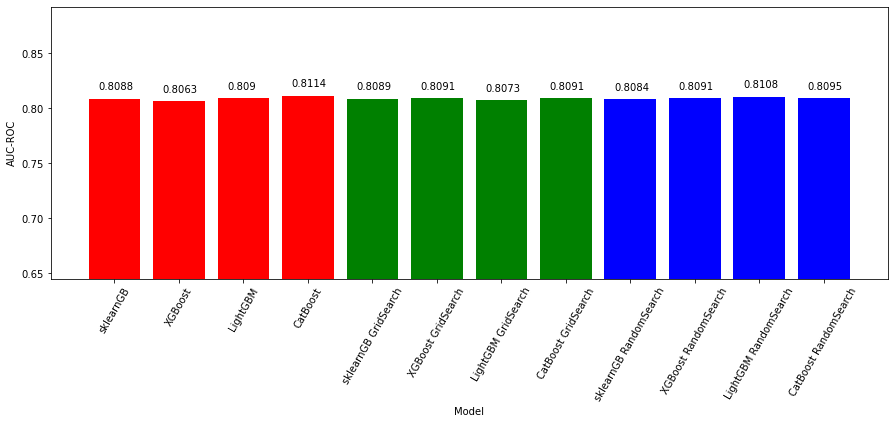

In [72]:
model_scores = pd.DataFrame({ 'Model': [name for name in models], 'AUC-ROC': np.round(scores_total[0], 4) })
# model_scores.sort_values(by='AUC-ROC',ascending=False,inplace=True)
plot_metric(model_scores, compare_mode = 'AUC-ROC')

**Время для трейна**

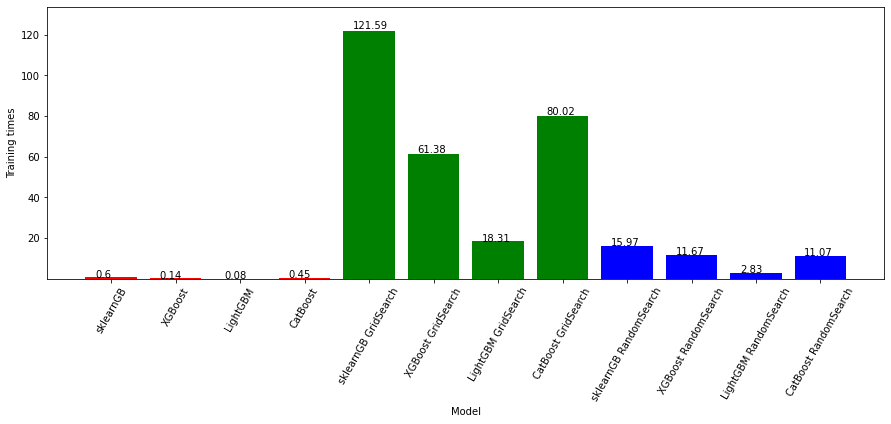

In [73]:
model_training_times = pd.DataFrame({ 'Model': [name for name in models], 'Training times': np.round(train_time_total[0], 2) })
# model_training_times.sort_values(by='Training times',ascending=False,inplace=True)
plot_metric(model_training_times, compare_mode = 'Training times')

**Время для предсказания**

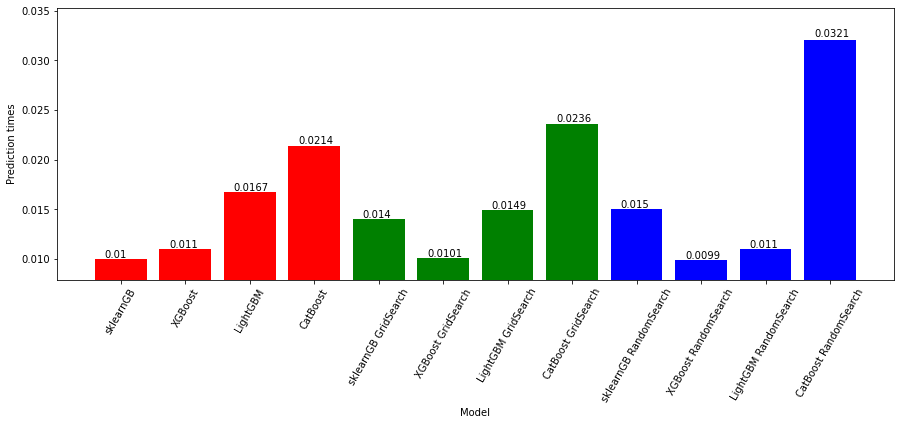

In [74]:
model_pred_times = pd.DataFrame({ 'Model': [name for name in models], 'Prediction times': np.round(pred_time_total[0], 4) })
# model_pred_times.sort_values(by='Prediction times',ascending=False,inplace=True)
plot_metric(model_pred_times, compare_mode = 'Prediction times')

#### Метрика 2: Accuracy

**Значения метрик**

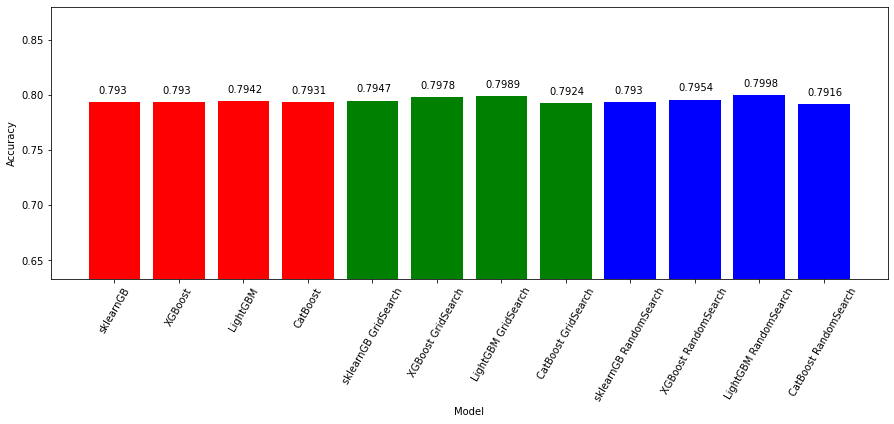

In [75]:
model_scores = pd.DataFrame({ 'Model': [name for name in models], 'Accuracy': np.round(scores_total[1], 4) })
# model_scores.sort_values(by='AUC-ROC',ascending=False,inplace=True)
plot_metric(model_scores, compare_mode = 'Accuracy')

**Время для трейна**

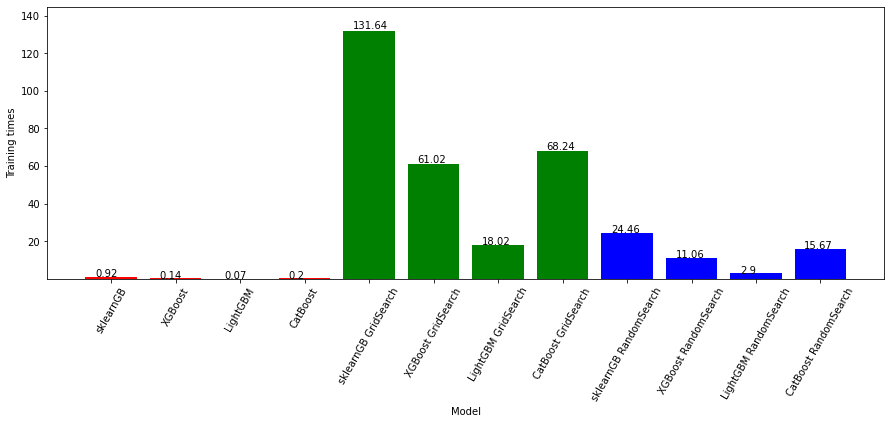

In [76]:
model_training_times = pd.DataFrame({ 'Model': [name for name in models], 'Training times': np.round(train_time_total[1], 2) })
# model_training_times.sort_values(by='Training times',ascending=False,inplace=True)
plot_metric(model_training_times, compare_mode = 'Training times')

**Время для предсказания**

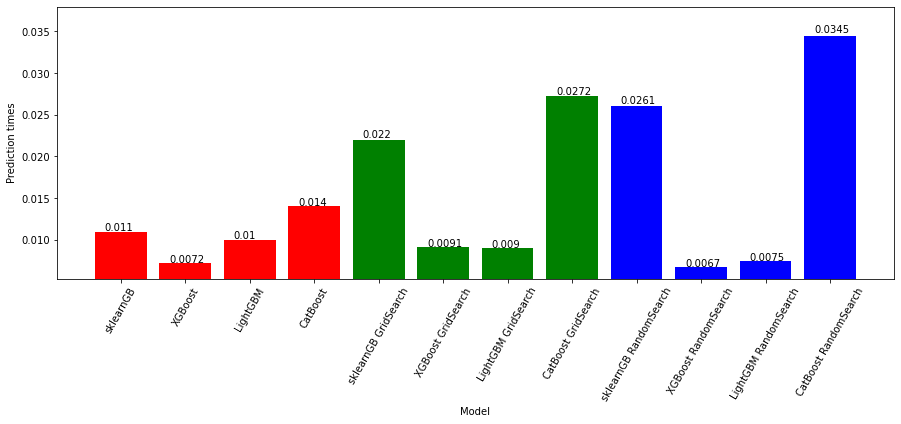

In [77]:
model_pred_times = pd.DataFrame({ 'Model': [name for name in models], 'Prediction times': np.round(pred_time_total[1], 4) })
# model_pred_times.sort_values(by='Prediction times',ascending=False,inplace=True)
plot_metric(model_pred_times, compare_mode = 'Prediction times')

#### Метрика 3: F1

**Значения метрик**

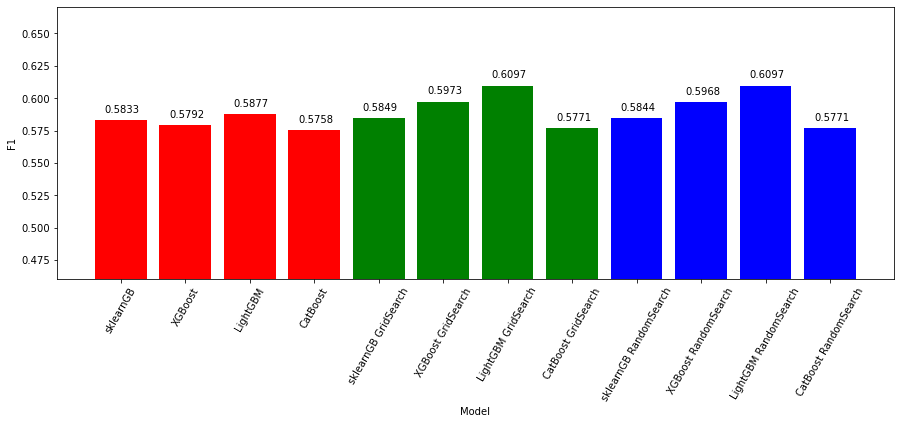

In [78]:
model_scores = pd.DataFrame({ 'Model': [name for name in models], 'F1': np.round(scores_total[2], 4) })
# model_scores.sort_values(by='AUC-ROC',ascending=False,inplace=True)
plot_metric(model_scores, compare_mode = 'F1')

**Время для трейна**

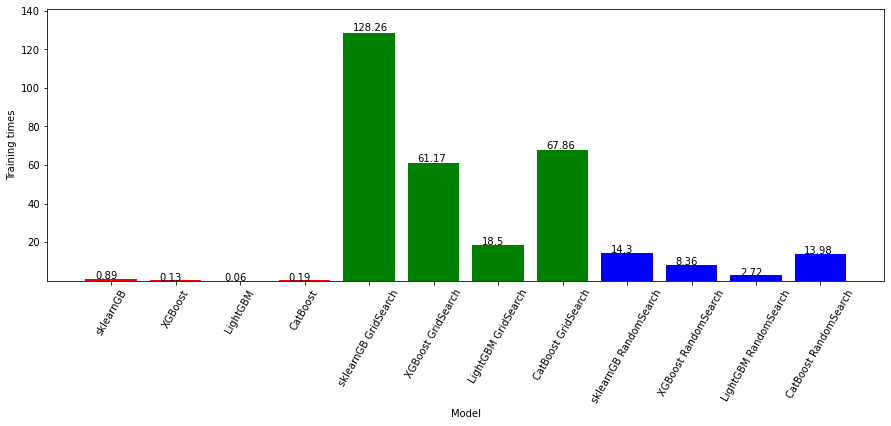

In [79]:
model_training_times = pd.DataFrame({ 'Model': [name for name in models], 'Training times': np.round(train_time_total[2], 2) })
# model_training_times.sort_values(by='Training times',ascending=False,inplace=True)
plot_metric(model_training_times, compare_mode = 'Training times')

**Время для предсказания**

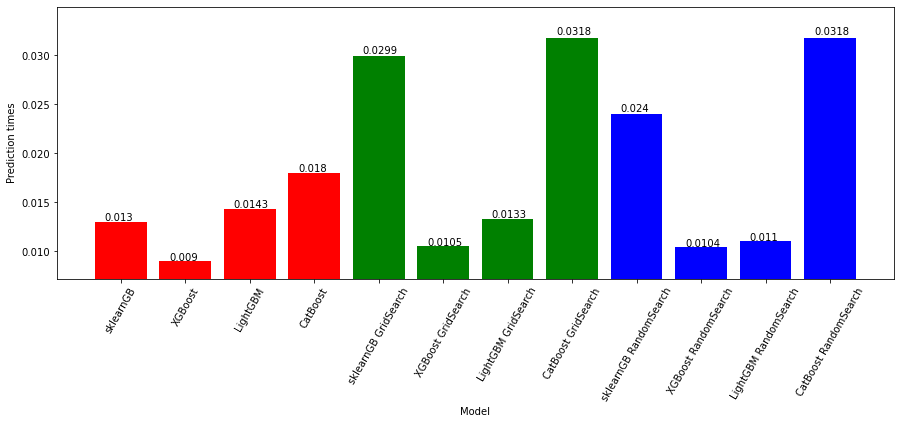

In [80]:
model_pred_times = pd.DataFrame({ 'Model': [name for name in models], 'Prediction times': np.round(pred_time_total[2], 4) })
# model_pred_times.sort_values(by='Prediction times',ascending=False,inplace=True)
plot_metric(model_pred_times, compare_mode = 'Prediction times')

## 4. Выводы
1. Качества моделей
    - Нет "явных" победителей - на всех трех метриках показаны, что бустинги построили модели с приближенными равными качествами. Это вывод поддерживается и в многих подобных сравнений бустинга.
    - Оптимизация гиперпараметров не дала сильной прирост. Это объяснится тем, что при сравнении используется датасет с не большим объемом данных, поэтому место для улучшения моделей с подбором гиперпараметров не большое. 
    - При использовании RandomizedSearch давалась модель с равным качеством модели, которую тюнила с GridSearch, при этом скорость трейна 4х быстрее чем GridSearch. Это в свою очередь означает, что при подборе гиперпараметров рекомендуется использовать разные виды оптимизации кроме поиска по сетке, например - можно использовать случайный поиск, или байесовскую оптимизацию, которая уже реализована разными библиотеками.
    
    
2. Скорость трейна и прогноза
    - LightGBM - самый быстрый на трейне - 3х быстрее XGBoost, 3-4х быстрее CatBoost по экспериментам. А реализация в sklearn оказывается самой медленной среди всех реализацией.
    - Скорости при прогнозе: XGBoost > sklearnGB > LightGBM > CatBoost. Модели с тюнигом прогнозируют подольше. Но поскольку все модели прогнозируют где-то 0.01-0.03 сек., поэтому отличие может не учитываться.
3. Про дисбаланс датасета: присутствует дисбаланс таргет-значений, который потенциально влияет на прогноз. Поэтомй попробовал использовать Over-Sampling SMOTE. Но это не помогло.
